In [1]:
from collections import Counter
from tqdm import *
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from seqeval.metrics import *
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,SpatialDropout1D
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Function to parse NER Data

In [2]:
def convert_data(path):
    sents = []
    sent = []
    for line in tqdm(open(path)):
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sents.append(sent)
                sent = []
            continue
        splits = line.split(' ')
        sent.append((splits[0].lower(), splits[-1].strip("\n")))

    if len(sentence) > 0:
        sents.append(sent)
        sent = []
    return sents

In [3]:
train_data = convert_data("./train.txt")
val_data   = convert_data("./valid.txt")
test_data  = convert_data("./test.txt")

219554it [00:00, 814895.77it/s]
55044it [00:00, 402171.31it/s]
50350it [00:00, 886475.17it/s]


In [4]:
tags  = set()
words = set()

In [5]:
def extract_word_label(data):
    for sentence in data:
        for i in range(len(sentence)):
            tags.add(sentence[i][-1])
            words.add(sentence[i][0])

In [6]:
extract_word_label(train_data)
extract_word_label(val_data)
extract_word_label(test_data)

#### plot to check doc length for train data

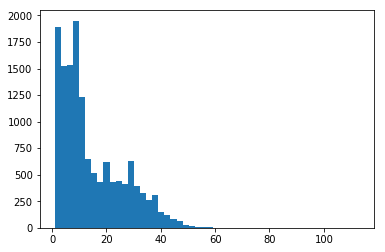

In [7]:
plt.hist([len(s) for s in train_data],bins=50)
plt.show()

#### plot to check doc length for val data

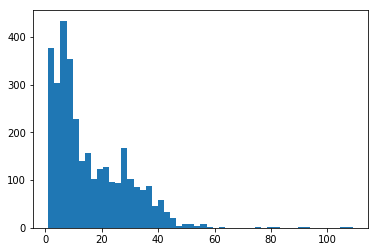

In [8]:
plt.hist([len(s) for s in val_data],bins=50)
plt.show()

#### getting maximum sentence length from train & val data. assign max as maxlen for padding 

In [9]:
sentences_train_len = [len(s) for s in train_data]
sentences_val_len = [len(s) for s in val_data]

In [10]:
maxlen_train = int(np.percentile(sentences_train_len,99))
maxlen_val   = int(np.percentile(sentences_val_len,99))

In [11]:
maxlen = max(maxlen_train,maxlen_val)

In [12]:
maxlen

49

#### Number of Unique words & Tags

In [13]:
len(words), len(tags)

(26869, 9)

In [14]:
words = list(words)

#### Converting words and tags to numerical representation. Here, i have assisgned 1 as UNK words, 0 for Padding. Therefore, i have started word index from 2. Similarly Tags from 1 to 9 & 0 for Padding.

In [15]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx  = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [16]:
X_train = [[word2idx[w[0]] for w in s] for s in train_data]

In [17]:
X_train = pad_sequences(maxlen=maxlen, sequences=X_train, value=word2idx["PAD"], padding='post', truncating='post')

In [18]:
y_train = [[tag2idx[w[1]] for w in s] for s in train_data]

In [19]:
y_train = pad_sequences(maxlen=maxlen, sequences=y_train, value=tag2idx["PAD"], padding='post', truncating='post')

In [20]:
y_train = [to_categorical(i, num_classes=len(tag2idx)) for i in y_train]

In [21]:
X_val = [[word2idx[w[0]] for w in s] for s in val_data]

In [22]:
X_val = pad_sequences(maxlen=maxlen, sequences=X_val, value=word2idx["PAD"], padding='post', truncating='post')

In [23]:
y_val = [[tag2idx[w[1]] for w in s] for s in val_data]

In [24]:
y_val = pad_sequences(maxlen=maxlen, sequences=y_val, value=tag2idx["PAD"], padding='post', truncating='post')

In [25]:
y_val = [to_categorical(i, num_classes=len(tag2idx)) for i in y_val]

#### Model Definition

In [29]:
EMBEDDING_DIM = 50
inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=len(word2idx), 
                            output_dim=EMBEDDING_DIM, 
                            input_length=maxlen, 
                            mask_zero=True)(inputs)

emb = SpatialDropout1D(0.2)(embedding_layer)
lstm_layer = Bidirectional(LSTM(units=100, return_sequences=True))(emb)
output = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(lstm_layer)

model = Model(inputs, output)

In [30]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 49)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 49, 50)            1343550   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 49, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 49, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 49, 10)            2010      
Total params: 1,466,360
Trainable params: 1,466,360
Non-trainable params: 0
_________________________________________________________________


In [32]:
checkpoint = ModelCheckpoint('model_check_point.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

In [33]:
history = model.fit(np.array(X_train),np.array(y_train), 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(np.array(X_val),np.array(y_val)),
                    callbacks= [checkpoint, early_stop],
                    verbose=1)

Train on 14041 samples, validate on 3250 samples
Epoch 1/30
14041/14041 [==============================] - 89s 6ms/step - loss: 0.6179 - acc: 0.8490 - val_loss: 0.4159 - val_acc: 0.8804

Epoch 00001: val_acc improved from -inf to 0.88044, saving model to model_check_point.h5
Epoch 2/30
14041/14041 [==============================] - 102s 7ms/step - loss: 0.2500 - acc: 0.9241 - val_loss: 0.2629 - val_acc: 0.9323

Epoch 00002: val_acc improved from 0.88044 to 0.93232, saving model to model_check_point.h5
Epoch 3/30
14041/14041 [==============================] - 105s 7ms/step - loss: 0.1251 - acc: 0.9660 - val_loss: 0.1989 - val_acc: 0.9469

Epoch 00003: val_acc improved from 0.93232 to 0.94693, saving model to model_check_point.h5
Epoch 4/30
14041/14041 [==============================] - 102s 7ms/step - loss: 0.0724 - acc: 0.9801 - val_loss: 0.1866 - val_acc: 0.9520

Epoch 00004: val_acc improved from 0.94693 to 0.95202, saving model to model_check_point.h5
Epoch 5/30
14041/14041 [=======